In [3]:
# Import Packages
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import glob

os.environ["TF_ENABLE_MLIR"] = "1"
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"
os.environ["TF_USE_LEGACY_GPU_KERNELS"] = "1"

import subprocess
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

In [4]:
# Review GPU/CPU
subprocess.run(["system_profiler", "SPDisplaysDataType"])

Graphics/Displays:

    Apple M4 Max:

      Chipset Model: Apple M4 Max
      Type: GPU
      Bus: Built-In
      Total Number of Cores: 40
      Vendor: Apple (0x106b)
      Metal Support: Metal 3
      Displays:
        LS34A650U:
          Resolution: 3440 x 1440 (UWQHD - Ultra-Wide Quad HD)
          UI Looks like: 3440 x 1440 @ 100.00Hz
          Main Display: Yes
          Mirror: Off
          Online: Yes
          Rotation: Supported



CompletedProcess(args=['system_profiler', 'SPDisplaysDataType'], returncode=0)

In [5]:
# Hard-coded parameters
# This is the best combination of parameters to get the spectrograms to appear properly
SAMPLE_RATE = 40000  # 16kHz sampling rate
AUDIO_LENGTH = 1     # 3 seconds max
F_MIN, F_MAX = 0, 1500
SPEC_HEIGHT, SPEC_WIDTH = 120, 80  # Height (mel bands) and fixed width for x seconds
# SHAPE_HEIGHT, SHAPE_WIDTH = 257, 1491

In [12]:
# A preprocess function for converting audio into tensorflow format
def preprocess(file_path, label):
    # Handle both tensor and string inputs
    if isinstance(file_path, tf.Tensor):
        file_path = file_path.numpy().decode('utf-8')

    # Load audio file (16 kHz, mono)
    wav, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    # Ensure 5 seconds (pad if shorter, trim if longer)
    target_length = SAMPLE_RATE * AUDIO_LENGTH
    wav = np.pad(wav[:target_length], (0, max(0, target_length - len(wav))), mode="constant")

    # Compute Mel spectrogram (50-800 Hz)
    mel_spec = librosa.feature.melspectrogram(
        y=wav, sr=sr, n_mels=SPEC_HEIGHT, fmin=F_MIN, fmax=F_MAX, hop_length=512
    )

    # Convert power to dB (ref=1.0 ensures negative dB values)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=1.0)
    
    # Zero pad to ensure uniform time length (500 frames)
    pad_width = [[0, 0], [0, max(0, SPEC_WIDTH - mel_spec_db.shape[1])]]
    mel_spec_db = np.pad(mel_spec_db, pad_width, mode='constant', constant_values=0)

    # Ensure a fixed size using resizing
    mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)  # Add channel dim
    mel_spec_db = tf.image.resize(mel_spec_db, (SPEC_HEIGHT, SPEC_WIDTH))  # Resize
    mel_spec_db.set_shape((SPEC_HEIGHT, SPEC_WIDTH, 1))

    # Convert to TensorFlow tensor and normalize (excluding padded silence)
    mel_tensor = tf.convert_to_tensor(mel_spec_db, dtype=tf.float32)

    # # Normalize only non-padded values
    # non_silent_mask = tf.not_equal(mel_tensor, -80.0)
    # valid_values = tf.boolean_mask(mel_tensor, non_silent_mask)
    # mean, std = tf.reduce_mean(valid_values), tf.math.reduce_std(valid_values)

    # # Apply normalization safely
    # mel_tensor = (mel_tensor - mean) / (std + 1e-6)

    return mel_tensor, label


In [7]:
# Apply function within a TensorFlow Dataset
def load_and_preprocess(file_path, label):
    spectrogram, label = tf.py_function(preprocess, [file_path, label], [tf.float32, tf.int32])
    spectrogram.set_shape((SPEC_HEIGHT, SPEC_WIDTH, 1))  # Ensure fixed shape
    return spectrogram, label

In [8]:
POS = os.getcwd().replace("/_scripts", "/_data/Audio/CRLF/Definitive/CRLF - Columns with WAAAA")
NEG = os.getcwd().replace("/_scripts", "/_data/Audio/notCRLF")

# Search recursively for WAV files in subdirectories
pos_files = glob.glob(os.path.join(POS, "**/*.wav"), recursive=True)
pos_files = tf.data.Dataset.list_files(pos_files, shuffle=False)

neg_files = glob.glob(os.path.join(NEG, "**/*.wav"), recursive=True)
neg_files = tf.data.Dataset.list_files(neg_files, shuffle=False)

# Check if files are loaded
print(f"Positive samples: {len(list(pos_files))}")
print(f"Negative samples: {len(list(neg_files))}")

Positive samples: 65
Negative samples: 971


2025-03-12 23:09:36.791385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-12 23:09:36.812478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
# Function to load each file and get its duration
def get_audio_duration(file_path):
    # Convert tensor to string for file path
    file_path = file_path.numpy().decode('utf-8')
    # Load audio and calculate duration
    wav, sr = librosa.load(file_path, sr=None)
    duration = len(wav) / sr
    return duration

# Wrap in tf.py_function to work with tf.data.Dataset
def tf_get_audio_duration(file_path):
    return tf.py_function(get_audio_duration, [file_path], tf.float32)

# Apply function to dataset and collect durations
durations = pos_files.map(tf_get_audio_duration)

# Convert dataset to a list of durations
durations_list = list(durations.as_numpy_iterator())

# Calculate min, max, and average duration
min_duration = min(durations_list)
max_duration = max(durations_list)
avg_duration = sum(durations_list) / len(durations_list)

# Display results
print(f"Minimum duration: {min_duration:.2f} seconds")
print(f"Maximum duration: {max_duration:.2f} seconds")
print(f"Average duration: {avg_duration:.2f} seconds")


Minimum duration: 0.11 seconds
Maximum duration: 4.84 seconds
Average duration: 2.40 seconds


2025-03-12 23:09:47.401070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


/Users/ec/Documents/Data/Frog-Call-Classifier/_data/Audio/CRLF/Definitive/CRLF - Columns with WAAAA/S4A14476_20240206_050501_Bear5.wav
0.1798639455782313


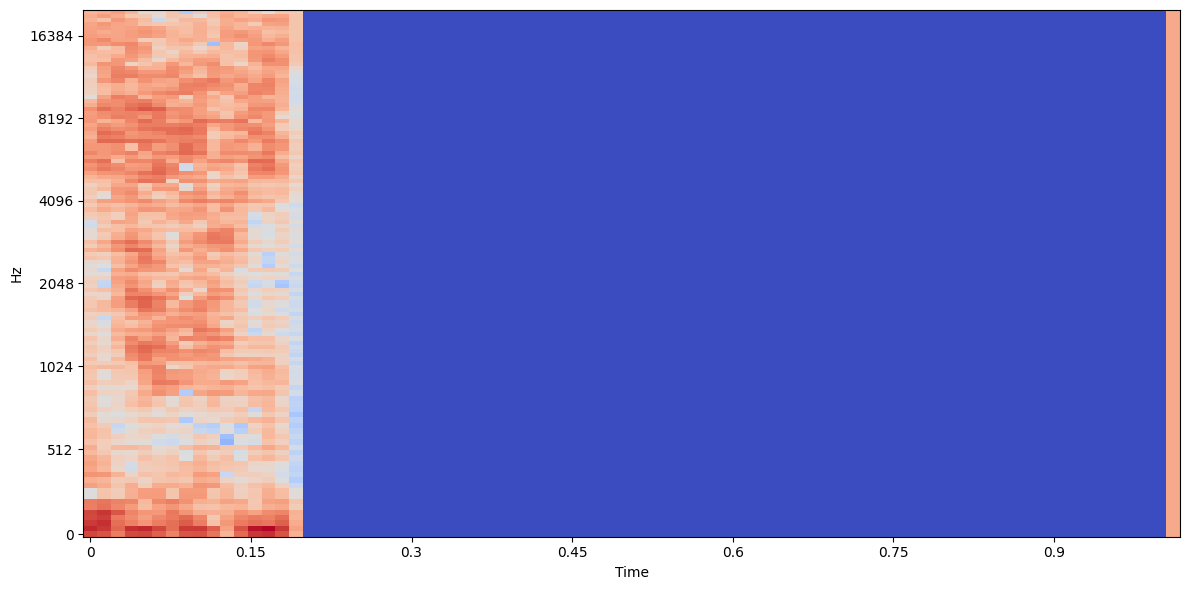

In [ ]:
def plot_spectrogram(spectrogram, sr=SAMPLE_RATE, filename="spectrogram_input.png"):
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(spectrogram.numpy().squeeze(), sr=sr, hop_length=512, x_axis='time', y_axis='mel', fmin=0)
    # plt.axis('off')  # Turn off axes completely
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Shuffle to randomize order
shuffled_files = pos_files.shuffle(buffer_size=100)
file_path = next(iter(shuffled_files)).numpy().decode('utf-8')
print(file_path)

wav, sr = librosa.load(file_path)
total_duration = librosa.get_duration(y=wav)
print(total_duration)

# Test with one sample
mel_spec, _ = preprocess(file_path, 1)
filename = os.getcwd().replace("/_scripts","/_results/Model/spectrogram_input.png")
plot_spectrogram(mel_spec, filename=filename)


In [160]:
# Apply preprocessing
positives = pos_files.map(lambda x: load_and_preprocess(x, 1))
negatives = neg_files.map(lambda x: load_and_preprocess(x, 0))

# Combine datasets
data = positives.concatenate(negatives)

In [161]:
# reshape the data
data = data.map(lambda x, y: (x, tf.reshape(y, [-1])))


In [162]:
# Split into training (80%) and testing (20%)
dataset_size = len(list(data))  # Count dataset size
test_size = int(0.2 * dataset_size)  # 20% test
train_size = dataset_size - test_size  # 80% train

# Take the first 80% as training data
train_data = data.take(train_size)

# Skip the first 80% and take the remaining 20% as test data
test_data = data.skip(train_size)

# Shuffle, batch, and prefetch
train_data = train_data.shuffle(1000).batch(16, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(16, drop_remainder=True).prefetch(tf.data.AUTOTUNE)  # No shuffle for test set

2025-03-07 08:24:49.302401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [93]:
# Shuffle, batch, and prefetch
# data = data.shuffle(1000).batch(16, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [163]:
dataset_size = sum(1 for _ in data)
print(f"Final dataset size: {dataset_size}")

dataset_size_train = sum(1 for _ in train_data)
print(f"Training dataset size: {dataset_size_train}")

dataset_size_test = sum(1 for _ in test_data)
print(f"Testing dataset size: {dataset_size_test}")

2025-03-07 08:25:15.826577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Final dataset size: 1036


2025-03-07 08:25:33.424843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training dataset size: 51
Testing dataset size: 12


2025-03-07 08:25:54.227800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [164]:
for sample_wav, sample_label in train_data.take(1):
    print("Waveform shape:", sample_wav.shape) # Expected: (16, 128, 344, 1)
    print("Label shape:", sample_label.shape) # Expected: (16,)
    print("Label values:", sample_label.numpy())

Waveform shape: (16, 120, 80, 1)
Label shape: (16, 1)
Label values: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


2025-03-07 08:27:24.762035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [165]:
# Define CNN Model
def build_model():
    model = models.Sequential([
    # Input layer
    layers.Input(shape=(SPEC_HEIGHT, SPEC_WIDTH, 1)),

    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Flatten and Dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    # Output layer
    layers.Dense(1, activation='sigmoid')
    
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = build_model()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 120, 80, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 120, 80, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 60, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 19200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,915,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,025,537 (19.17 MB)

 Trainable params: 5,025,089 (19.17 MB)

 Non-trainable params: 448 (1.75 KB)

In [166]:
print(f"Model expects: {model.input_shape}")


Model expects: (None, 120, 80, 1)


In [167]:
# Train the model
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_data, validation_data = test_data, epochs=15) #, callbacks=[early_stopping]) # 18

Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 43s 472ms/step - accuracy: 0.8625 - loss: 1.3317 - val_accuracy: 0.0521 - val_loss: 1.7606
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 44s 404ms/step - accuracy: 0.8970 - loss: 1.3233 - val_accuracy: 0.1354 - val_loss: 1.6542
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 508ms/step - accuracy: 0.9427 - loss: 0.8248 - val_accuracy: 0.5833 - val_loss: 0.8646
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 508ms/step - accuracy: 0.9406 - loss: 0.9061 - val_accuracy: 0.6875 - val_loss: 0.8504
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 480ms/step - accuracy: 0.9710 - loss: 0.3557 - val_accuracy: 0.9115 - val_loss: 0.2620
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 39s 427ms/step - accuracy: 0.9802 - loss: 0.2415 - val_accuracy: 0.9740 - val_loss: 0.1017
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 488ms/step - accuracy: 0.9735 - loss: 0.3942 - val_accuracy: 0.9896 - val_loss: 0.0194
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 609ms/step - accuracy: 0.9817 - loss: 0.2662 - val_accu

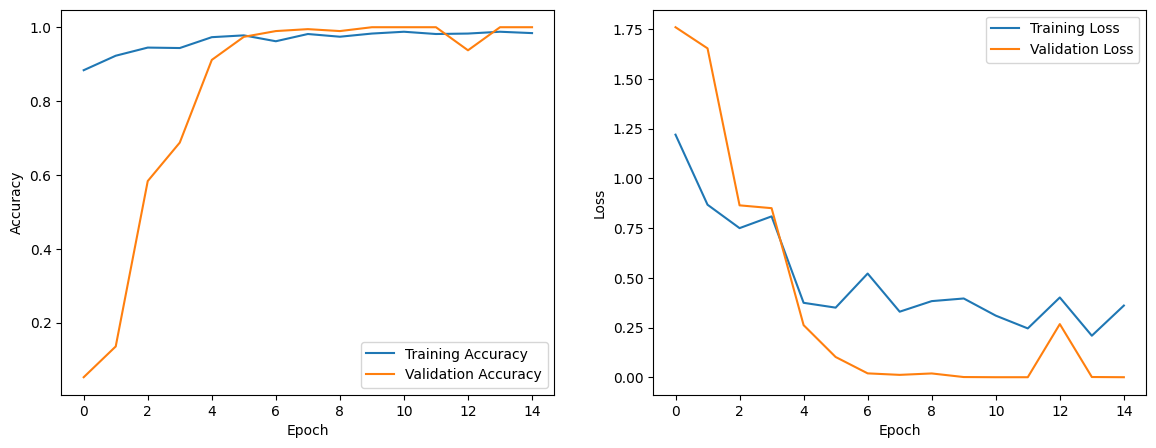

In [168]:
def plot_history(history, filename="training_history.png"):
    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Save the plot to a file
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Call the function and save the plot
filename = os.getcwd().replace("/_scripts","/_results/Model/training_history.png")
plot_history(history, filename=filename)

In [170]:
final_loss = history.history['loss'][-1]
final_accuracy = history.history['accuracy'][-1]
print(f"Final Training Loss: {final_loss:.4f}")
print(f"Final Training Accuracy: {final_accuracy:.4f}")


Final Training Loss: 0.3605
Final Training Accuracy: 0.9841


In [171]:
filename = os.getcwd().replace("/_scripts","/_results/Model/my_model.keras")
model.save(filename)